## Setup

In [ ]:
import os

from dataclasses import asdict
from pathlib import Path
from typing import Tuple

import torch
import pandas as pd
import matplotlib
import seaborn as sns

from matplotlib.colors import to_rgba
from transformers.hf_argparser import HfArgumentParser

from procyon.data.it_data_config import (
    expand_datasets_on_splits,
    ITMultiDatasetConfig,
)
from procyon.evaluate.framework.args import EvalArgs
from procyon.evaluate.framework.utils import (
    load_and_validate_model_args,
    override_data_and_model_args,
)
from procyon.training.training_args_IT import (
    DataArgs,
    ModelArgs,
    update_data_args_data_dir,
)

In [ ]:
base_path = Path("/n/home08/rcalef/sandbox/projects/txplm/canonical_evals/")

our_model_name = "ProCyon"

## Check new splits

In [ ]:
eval_path = base_path / "eval_new_splits"
config_yml = eval_path / "args.yml"

In [ ]:
retrieval_dirs = {
    base_path / "eval_new_splits": ["ProCyon"],
    base_path / "new_split_evals" / "zero_shot_baselines": ["BioTranslator", "ProtST"],
    base_path / "new_split_evals" / "simple_baselines": [
        "BlastKnn",
        "ESM3Knn",
        "ESM3MLP",
        "ESMKnn",
        "ESMMLP",
        "GearNetKnn",
        "GearNetMLP",
        "MajorityRule",
        "UniformRandom",
        "WeightedRandom",
    ],
}

retrieval_dir_by_model = {
    model: path for path, models in retrieval_dirs.items() for model in models
}

zero_shot_models = [
    "ProCyon",
    "BioTranslator",
    "ProtST",
]

In [ ]:
# Use ProCyon evals to get datasets
config_yml = retrieval_dir_by_model["ProCyon"] / "args.yml"
parser = HfArgumentParser((EvalArgs, DataArgs, ModelArgs))
eval_args, data_args, model_args = parser.parse_yaml_file(config_yml)

separate_splits = True
keep_splits_union = False

# Check if we want to override ModelArgs using a ProCyon checkpoint
if eval_args.model_args_from_checkpoint != "":
    checkpoint_dir = eval_args.model_args_from_checkpoint
    print(f"Loading ModelArgs from ProCyon checkpoint: {checkpoint_dir}")
    model_args = torch.load(os.path.join(checkpoint_dir, "model_args.pt"))
    model_args = ModelArgs(**asdict(model_args))

if eval_args.data_args_from_checkpoint != "":
    checkpoint_dir = eval_args.data_args_from_checkpoint
    print(f"Loading DataArgs from ProCyon checkpoint: {checkpoint_dir}")
    loaded_data_args = torch.load(os.path.join(checkpoint_dir, "data_args.pt"))
    loaded_data_args = DataArgs(**asdict(loaded_data_args))

    update_data_args_data_dir(loaded_data_args)

    # Prefer to use the data config specified in data_args passed into this function
    # over one specified in the serialized data config.
    if data_args.it_data_config_yml is not None:
        loaded_data_args.it_data_config_yml = data_args.it_data_config_yml
    data_args = loaded_data_args

# Check if we want to override any of the DataArgs or ModelArgs values parsed
# from the model checkpoint.
if eval_args.override_model_data_args_yml is not None:
    override_data_and_model_args(
        data_args, model_args, eval_args.override_model_data_args_yml
    )

# Parse model specifications.
models = load_and_validate_model_args(eval_args.models_config_yml)

config = ITMultiDatasetConfig.load_from_yaml(data_args.it_data_config_yml)
if separate_splits:
    config.testing_datasets = expand_datasets_on_splits(
        config.testing_datasets, keep_splits_union
    )

In [ ]:
for dset in config.testing_datasets:
    for relation in dset.relations:
        print(dset._construct_key(relation))

In [ ]:
func_task = "Protein function"
comp_task = "Cellular component"
path_task = "Biological pathway"
targ_task = "Drug target"
dpi_task = "Drug-protein interaction"
dis_task = "Disease association"
ec_task = "EC number"
dom_task = "Protein domains"

task_order = [
    func_task,
    comp_task,
    path_task,
    ec_task,
    targ_task,
    dpi_task,
    dis_task,
    #dom_task,
]

task_map = {
    'protein_go:process': func_task,
    'protein_go:function': func_task,
    'protein_reactome:all': path_task,
    'protein_go:component': comp_task,
    'protein_drugbank:drug_target': targ_task,
    'protein_drugbank:drug_enzyme': dpi_task,
    'protein_drugbank:drug_carrier': dpi_task,
    'protein_drugbank:drug_transporter':  dpi_task,
    'protein_disgenet:all': dis_task,
    'protein_omim:all': dis_task,
    'protein_ec:all': ec_task,
    'domain_pfam:all': dom_task,
    'domain_go:process': dom_task,
    'domain_go:function': dom_task,
    'domain_go:component': dom_task
}

In [155]:
_split_maps = {
    "pt_ft": ["pt_ft"],
    "few_shot": ["few_shot", "zero_shot_easy", "zero_shot"],
    "zero_shot": ["zero_shot_hard"],
}
split_maps = {
    x : k for k, v in _split_maps.items() for x in v
}

def map_split(x):
    return split_maps.get(x, "few_shot")

_split_maps_old = {
    "pt_ft": ["pt_ft"],
    "few_shot": ["few_shot"],
    "zero_shot": ["zero_shot", "zero_shot_hard"],
}
split_maps_old = {
    x : k for k, v in _split_maps_old.items() for x in v
}

def map_split_old(x):
    return split_maps_old.get(x, "few_shot")

def parse_dataset_string(s: str) -> Tuple[str, str, str]:
    aaseq, text, oth = s.split("_", maxsplit=2)
    if "eval" in oth:
        relation, split = [x.strip("_").rstrip("_") for x in oth.split("eval")]
        if split not in ["pt_ft", "zero_shot", "zero_shot_easy", "zero_shot_hard"]:
            split = "few_shot"
    else:
        relation = oth
        split = "all"
    return aaseq + "_" + text, relation, split


retrieval_path = eval_path / "retrieval" / "ProCyon"

def get_per_text_retrieval_results(model: str, key: str) -> pd.DataFrame:
    path = retrieval_dir_by_model[model] / "retrieval" / model/ key / "per_text_metrics.tsv"
    return pd.read_table(path)

def load_and_map(
    model: str,
    orig_key: str,
) -> pd.DataFrame:
    dataset, relation, split = parse_dataset_string(orig_key)
    mapped_split = map_split(split)

    dataset_relation = dataset + ":" + relation
    task = task_map[dataset_relation]

    return (
        get_per_text_retrieval_results(model, orig_key)
        .drop(columns=["sample_num"])
        .groupby("query_id")
        .mean()
        .reset_index()
        .assign(
            dataset_relation=dataset_relation,
            dataset=dataset,
            orig_split=split,
            orig_plot_split=map_split_old(split),
            plot_split=mapped_split,
            plot_task=task,
        )
    )

In [166]:
all_results = []
for dset in config.testing_datasets:
    for relation in dset.relations:
        dset_key = dset._construct_key(relation)
        for model in retrieval_dir_by_model.keys():
            if "zero_shot" in dset_key and model not in zero_shot_models:
                continue
            all_results.append(
                load_and_map(model, dset_key)
                .assign(model=model)
            )

all_results = pd.concat(all_results)
print(all_results.shape)
all_results.head()

(94846, 17)


,query_id,precision_k10,recall_k10,precision_k20,recall_k20,precision_k100,recall_k100,Fmax,auroc,auprc,dataset_relation,dataset,orig_split,orig_plot_split,plot_split,plot_task,model
0,0,0.30,0.750000,0.170000,0.85,0.090909,1.0,0.732857,0.881875,0.652682,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
1,1,0.20,1.000000,0.100000,1.00,0.090909,1.0,1.000000,1.000000,1.000000,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
2,5,0.20,1.000000,0.100000,1.00,0.090909,1.0,0.603175,0.887500,0.512143,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
3,8,0.22,0.733333,0.150000,1.00,0.090909,1.0,0.667619,0.881111,0.577133,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
4,9,0.10,1.000000,0.090909,1.00,0.090909,1.0,0.866667,0.970000,0.800000,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon


### Compare old splits vs new splits

In [ ]:
split_rename = {
    "pt_ft": "Text frequently\nseen in training",
    "few_shot": "Text rarely\nseen in training",
    "zero_shot": "Text never\nseen in training",
}
split_order = list(split_rename.values())

procyon_data = all_results.query("model == 'ProCyon'")
plot_data = (
    pd.concat((
        procyon_data[["Fmax", "plot_task", "plot_split"]].assign(split_groups="new"),
        (procyon_data[["Fmax", "plot_task", "orig_plot_split"]]
        .rename(columns={"orig_plot_split": "plot_split"})
        .assign(split_groups="old")),
    ))
    .assign(
        plot_split=lambda x: x.plot_split.map(split_rename),
        split_groups=lambda x: x.split_groups.str.title(),
    )
)
plot_data.head()

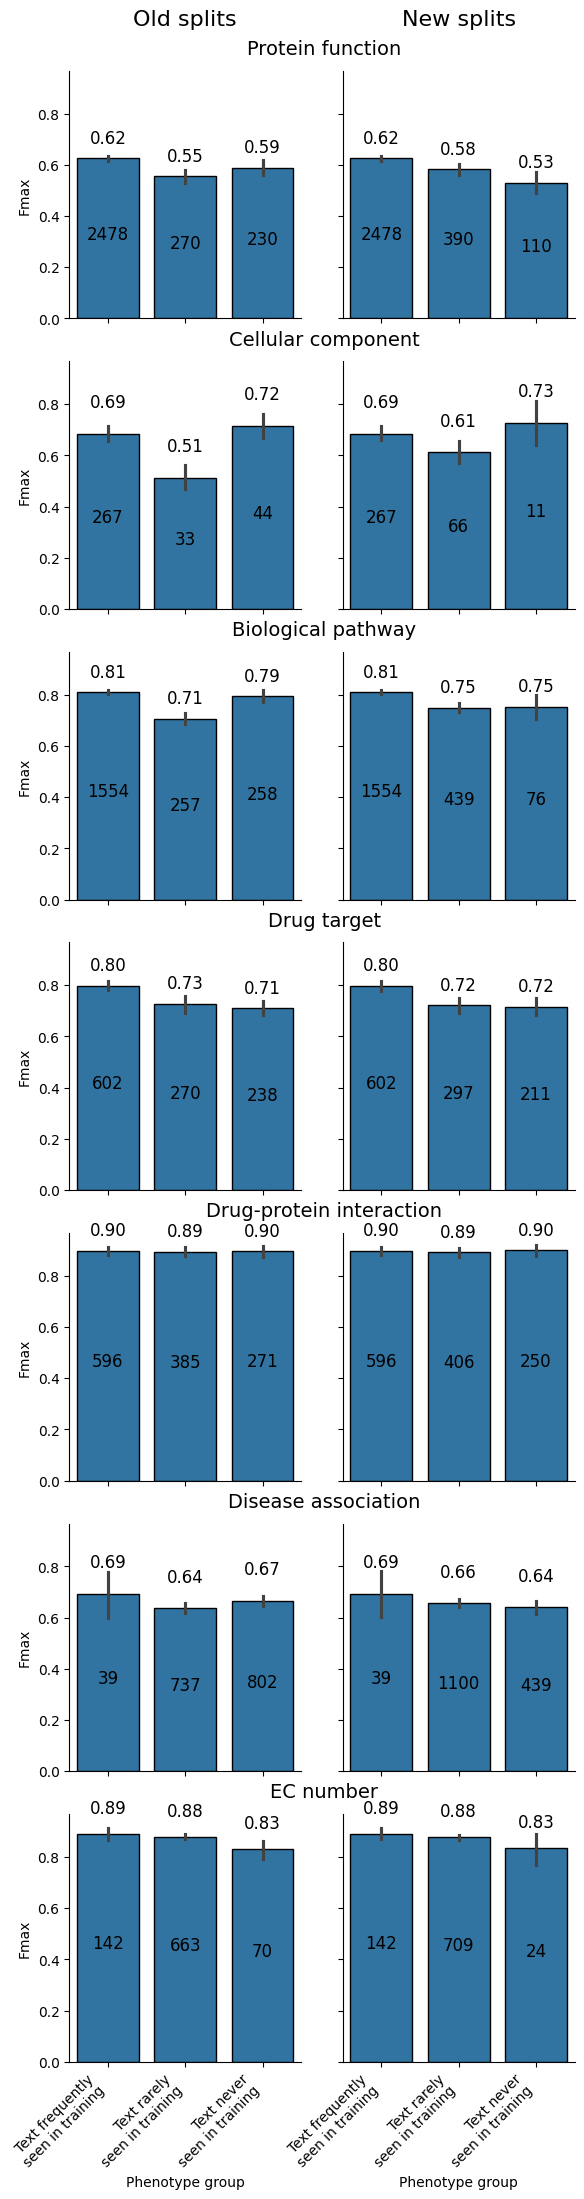

In [109]:
fg = sns.FacetGrid(
    data=plot_data,
    row="plot_task",
    col="split_groups",
    margin_titles=False,
    col_order=["Old", "New"],
)

fg.map_dataframe(
    sns.barplot,
    x="plot_split",
    y="Fmax",
    order=split_order,
    edgecolor="black",
)
# Set column titles only for the first row
for col_idx, col_name in enumerate(fg.col_names):
    fg.axes[0, col_idx].set_title(f"{col_name} splits", fontsize=16, y=1.15, fontweight="normal")

# Remove column titles for all other rows
for i in range(1, len(fg.row_names)):
    for j in range(len(fg.col_names)):
        fg.axes[i, j].set_title("")

# Add subtitles for each row
for i, row_val in enumerate(fg.row_names):

    ax = fg.axes[i, 0]  # Get leftmost axis for this row
    ax.annotate(
        row_val,
        xy=(1.1, 1.05),  # Above the top of the row
        xycoords="axes fraction",
        ha="center",
        va="bottom",
        fontsize=14,
        fontweight="normal"
    )

bottom_row_idx = len(fg.row_names) - 1  # Index of last row
for ax in fg.axes[bottom_row_idx, :]:
    for label in ax.get_xticklabels():
        label.set_rotation(45)  # Rotate labels 45 degrees
        label.set_ha("right")

fg.set_axis_labels(x_var="Phenotype group")

for (task, split_type), ax in fg.axes_dict.items():
    counts = (
        plot_data
        .query("split_groups == @split_type and plot_task == @task")
        .plot_split.value_counts()
        [split_order]
    )
    ax.bar_label(ax.containers[0], labels=counts, padding=3, fontsize=12, label_type="center")

    vals = (
        plot_data
        .query("split_groups == @split_type and plot_task == @task")
        .groupby("plot_split")
        .Fmax
        .mean()
        [split_order]
    )
    formatted_vals = vals.map(lambda v: f"{v:.2f}")
    if task in ["Cellular component", "Disease association"]:
        padding = 16
    elif task == "EC number":
        padding = 12
    else:
        padding = 8
    ax.bar_label(ax.containers[0], labels=formatted_vals, padding=padding, fontsize=12, label_type="edge")




## Retrieval performance

In [167]:
zero_shot_name = "ProCyon (zero shot)"

In [168]:
all_results.loc[lambda x: (x.model == "ProCyon") & (x.plot_split == "zero_shot"), "model"] = zero_shot_name

In [169]:
# We need different split maps here since most of the baselines
# can't handle the zero-shot phenotypes that we're treating as few-shot now.
_split_maps_retrieval = {
    "pt_ft": ["pt_ft"],
    "few_shot": ["few_shot"],
    "zero_shot": ["zero_shot_hard"],
}
split_maps_retrieval = {
    x : k for k, v in _split_maps_retrieval.items() for x in v
}

def map_split_retrieval(x):
    return split_maps_retrieval.get(x, "few_shot")

retrieval_data = (
    all_results
    .loc[lambda x: ~x.orig_split.isin(["zero_shot_easy", "zero_shot"])]
    .loc[lambda x: (x.plot_split != "zero_shot") | (x.model == zero_shot_name)]
)
retrieval_data.model.value_counts()


model
ProCyon                6658
BioTranslator          6658
ProtST                 6658
MajorityRule           6658
WeightedRandom         6658
UniformRandom          6658
ESM3MLP                6322
ESM3Knn                6322
BlastKnn               6322
ESMKnn                 6322
GearNetMLP             6322
GearNetKnn             6322
ESMMLP                 6322
ProCyon (zero shot)    1121
Name: count, dtype: int64

In [170]:
main_fig_models = {
    "BlastKnn": "BLAST-kNN",
    "ESM3MLP": "ESM3-MLP",
    "GearNetMLP": "GearNet-MLP",
    "BioTranslator": "BioTranslator",
    "ProCyon": "ProCyon",
    zero_shot_name: zero_shot_name,
}

model_order = list(main_fig_models.values())

In [171]:
plot_data = (
    retrieval_data
    .loc[lambda x: x.model.isin(main_fig_models)]
    .assign(model=lambda x: x.model.map(main_fig_models))
    .reset_index(drop=True)
)
plot_data.head()

,query_id,precision_k10,recall_k10,precision_k20,recall_k20,precision_k100,recall_k100,Fmax,auroc,auprc,dataset_relation,dataset,orig_split,orig_plot_split,plot_split,plot_task,model
0,0,0.30,0.750000,0.170000,0.85,0.090909,1.0,0.732857,0.881875,0.652682,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
1,1,0.20,1.000000,0.100000,1.00,0.090909,1.0,1.000000,1.000000,1.000000,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
2,5,0.20,1.000000,0.100000,1.00,0.090909,1.0,0.603175,0.887500,0.512143,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
3,8,0.22,0.733333,0.150000,1.00,0.090909,1.0,0.667619,0.881111,0.577133,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
4,9,0.10,1.000000,0.090909,1.00,0.090909,1.0,0.866667,0.970000,0.800000,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon


In [175]:
plot_data.model.value_counts()

model
ProCyon                6658
BioTranslator          6658
BLAST-kNN              6322
ESM3-MLP               6322
GearNet-MLP            6322
ProCyon (zero shot)    1121
Name: count, dtype: int64

In [205]:
alpha = 1
#txplm_color = to_rgba("fuchsia")
procyon_color = "#9467BD"

model_colors = {
    "BLAST-kNN": to_rgba("dodgerblue", alpha),
    "ESM3-MLP": to_rgba("deepskyblue", alpha),
    "GearNet-MLP": to_rgba("darkblue", alpha),
    "BioTranslator": to_rgba("firebrick", alpha),
    "ProtST": to_rgba("salmon", alpha),
    "ProtLLM": to_rgba("red", alpha),
    our_model_name: procyon_color,
    zero_shot_name: procyon_color,
}

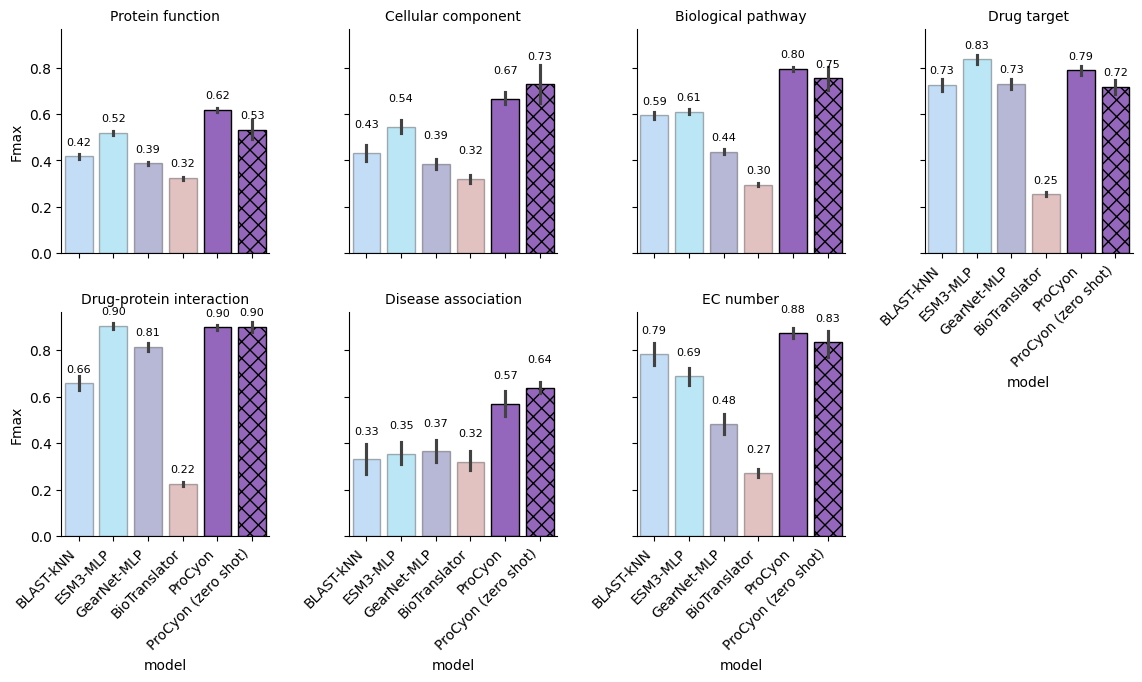

In [254]:
fg = sns.FacetGrid(
    data=plot_data,
    col="plot_task",
    col_wrap=4,
    margin_titles=True,
)

# fg.map_dataframe(
#     sns.barplot,
#     x="model",
#     y="Fmax",
#     order=model_order,
#     edgecolor="black",
#     hue="model",
#     palette=model_colors,
# )

fg.map_dataframe(
    sns.barplot,
    x="model",
    y="Fmax",
    order=[x for x in model_order if "ProCyon" not in x],
    edgecolor="black",
    hue="model",
    alpha=0.3,
    palette=model_colors,
    data=plot_data.loc[lambda x: ~x.model.str.contains("ProCyon")],
)

fg.map_dataframe(
    sns.barplot,
    x="model",
    y="Fmax",
    order=["ProCyon"],
    edgecolor="black",
    hue="model",
    alpha=1,
    saturation=1,
    palette=model_colors,
    data=plot_data.loc[lambda x: x.model.str.contains("ProCyon") & ~x.model.str.contains("zero")],
)

fg.map_dataframe(
    sns.barplot,
    x="model",
    y="Fmax",
    order=[zero_shot_name],
    edgecolor="black",
    hue="model",
    alpha=1,
    saturation=1,
    hatch="xx",
    palette=model_colors,
    data=plot_data.loc[lambda x: x.model.str.contains("ProCyon") & ~x.model.str.contains("zero")],
)


fg.set_titles(template="{col_name}")

for ax in fg.axes:
    if len(ax.get_xticklabels()) == 0:
        continue
    for label in ax.get_xticklabels():
        label.set_rotation(45)  # Rotate labels 45 degrees
        label.set_ha("right")


for task, ax in fg.axes_dict.items():
    # Get all visible bars in the axis
    all_patches = []
    for container in ax.containers:
        if isinstance(container, matplotlib.container.BarContainer):
            for patch in container:
                all_patches.append(patch)

    # Get the task-specific data and visible models
    task_data = plot_data.query("plot_task == @task")
    visible_models = []

    # Extract x-tick labels to know which models are actually shown
    for label in ax.get_xticklabels():
        if label.get_text() in task_data['model'].values:
            visible_models.append(label.get_text())

    # If no visible models found (sometimes happens with seaborn), try another approach
    if not visible_models:
        # Group bars by x-position (rounded to handle floating point issues)
        x_positions = sorted(set(round(patch.get_x(), 2) for patch in all_patches))

        # Get filtered data for this task, respecting the same filters you used for plotting
        models_shown = []

        # Add non-ProCyon models
        non_procyon = task_data.loc[lambda x: ~x.model.str.contains("ProCyon")]
        if not non_procyon.empty:
            models_in_order = [x for x in model_order if "ProCyon" not in x and x in non_procyon['model'].values]
            models_shown.extend(models_in_order)

        # Add regular ProCyon models
        procyon = task_data.loc[lambda x: x.model.str.contains("ProCyon") & ~x.model.str.contains("zero")]
        if not procyon.empty:
            if "ProCyon" in procyon['model'].values:
                models_shown.append("ProCyon")

        # Add zero-shot ProCyon model
        if zero_shot_name in task_data['model'].values:
            models_shown.append(zero_shot_name)

        visible_models = models_shown

    # Match bars to models based on position
    if len(visible_models) == len(x_positions) and len(all_patches) >= len(visible_models):
        # Create a mapping from x-position to model
        position_to_model = {pos: model for pos, model in zip(x_positions, visible_models)}

        # For each bar
        for patch in all_patches:
            # Find the closest x-position
            x_pos = round(patch.get_x(), 2)
            closest_pos = min(x_positions, key=lambda p: abs(p - x_pos))

            if closest_pos in position_to_model:
                model = position_to_model[closest_pos]
                # Get the value for this model in this task
                value = task_data[task_data['model'] == model]['Fmax'].mean()

                # Adjust padding based on task
                if task in ["Cellular component", "Disease association"]:
                    padding_mul = 2.5
                elif task == "EC number":
                    padding_mul = 2
                else:
                    padding_mul = 1

                # Add text above the bar
                ax.text(
                    patch.get_x() + patch.get_width() / 2,
                    patch.get_height() + (0.04 * padding_mul),
                    f"{value:.2f}",
                    ha="center",
                    va="bottom",
                    fontsize=8,
                )